<a href="https://colab.research.google.com/github/yhussain1/SentimentMLUiPath/blob/main/ReviewClass0_3Bare0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs, Imports and References
!pip install unidecode
!pip install ipython-autotime
%load_ext autotime

import re
import nltk
import unidecode
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_datasets as tfds

from numpy import array
from numpy import asarray
from numpy import zeros
from wordcloud import WordCloud 
from imblearn.over_sampling import RandomOverSampler
from plotly.subplots import make_subplots


nltk.download('popular')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer 

from keras_preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model


# https://www.kaggle.com/code/erickvarela/sentiment-analyse-deep-learn-amazon-app#6---Pipeline
# https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews
# https://www.youtube.com/watch?v=KGcPeowh6SQ&t=355s

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 21.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 26.3 MB/s 


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

time: 18.8 s (started: 2022-11-24 19:41:11 +00:00)


[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


In [ ]:
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

amazon_zip = "/content/amazon_reviews.csv" # Specify the path
final_zip = "/content/finalized_model.sav"

# Check whether the specified path exists or not
if os.path.exists(amazon_zip)== False :
  !unzip /content/drive/MyDrive/amazon_reviews.zip

if os.path.exists(final_zip)== False :
  !unzip /content/drive/MyDrive/finalized_model.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/amazon_reviews.zip
  inflating: amazon_reviews.csv      
Archive:  /content/drive/MyDrive/finalized_model.zip
  inflating: finalized_model.sav     
time: 33.5 s (started: 2022-11-24 19:41:30 +00:00)


In [ ]:
dff = pd.read_csv('amazon_reviews.csv', index_col=0)
dff.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


time: 696 ms (started: 2022-11-24 19:42:04 +00:00)


In [ ]:
df = pd.DataFrame()
df['score'] = dff['data/star_rating']
df['review'] = dff['data/review_body'].str.strip("b\'\"")
df = df[['review', 'score']]
df.head()

,review,score
0,Does not work,1
1,This is a great wiring kit i used it to set up...,4
2,It works great so much faster than USB charger...,5
3,This product was purchased to hold a monitor o...,5
4,it works but it has really bad sound quality. ...,3


time: 109 ms (started: 2022-11-24 19:42:04 +00:00)


In [ ]:
df['sentiment']='-'
df.loc[df['score']<=2,'sentiment']='negative'
df.loc[df['score']==3,'sentiment']='neutral'
df.loc[df['score']>=4,'sentiment']='positive'
df = pd.get_dummies(df,columns=['sentiment']).reset_index(drop=True).drop(columns=['score'])

df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,review,sentiment_negative,sentiment_neutral,sentiment_positive
104970,It's a wonderful invention. You don't need to ...,0,0,1
104971,"This is not good item,I can even maket work,th...",1,0,0
104972,The cover and skin were both exactly like the ...,0,0,1
104973,I ordered 2 of these cords for both mine and m...,1,0,0
104974,Item works better than I had hoped for. Very c...,0,0,1


time: 41.9 ms (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

# remove html tags and lower case
def re_tags(text_list):
  return[TAG_RE.sub('', str(word)).lower() for word in text_list]

# replace accented characters é, è, â, î or ô
def re_accented_char(text_list):
  return [unidecode.unidecode(word.encode().decode('utf-8')) for word in text_list]

# correct contraction, replace possible mistakes
# extend contractions with re
def ex_contractions(text_list):
  result=[]
  for word in text_list:

    # replace contracting without signal
    word = word.replace("wont","won't")
    word = word.replace("cant","can't")
    word = word.replace("its","it's")
    word = word.replace("youre","you're")
    word = word.replace("hes","he's")
    word = word.replace("shes","she's")
    word = word.replace("its","it's")
    word = word.replace("weare","we're")
    word = word.replace("theyre","they're")

    # specific
    word = re.sub(r"won\'t", "will not", str(word))
    word = re.sub(r"can\'t", "can not", str(word))
    word = re.sub(r"doesn\'t", "does not", str(word))

    # general
    word = re.sub(r"n\'t", " not", str(word))
    word = re.sub(r"\'re", " are", str(word))
    word = re.sub(r"\'s", " is", str(word))
    word = re.sub(r"\'d", " would", str(word))
    word = re.sub(r"\'ll", " will", str(word))
    word = re.sub(r"\'t", " not", str(word))
    word = re.sub(r"\'ve", " have", str(word))
    word = re.sub(r"\'m", " am", str(word))
    result.append(word)
  return result

# remove special characters
def re_special_chars(text_list):
  return [re.sub("[^a-zA-Z0-9]"," ",word) for word in text_list]

# lemmatise words
def lemmatize_text(text_list):
  wnl = WordNetLemmatizer()
  lemmatizer_sentence = []
  tokenizer = nltk.tokenize.WhitespaceTokenizer()
  for word in tokenizer.tokenize(text_list):
    lemmatizer_sentence.append(wnl.lemmatize (word, 'v'))
    lemmatizer_sentence.append(" ")
  return("".join(lemmatizer_sentence))

# tokenize sentence and then remove remove stop words from nltk stopwords list
def stopwords_text(text_list):
  stop = stopwords.words('english')
  sentence_without = []
  tokenizer = nltk.tokenize.WhitespaceTokenizer()
  for word in tokenizer.tokenize(text_list):
    if word not in stop:
      sentence_without.append(word)
      sentence_without.append(" ")

  return("".join(sentence_without))

# use nltk to check word is in english
words = set(nltk.corpus.words.words())
def word_check(text_list):
  result = []
  for word in text_list:
    if word.lower() in words:
      result.append(word)
  return result

# remove dupe whitespace and digits
def re_whitespaces(text_list):
  result=[]
  for word in text_list:
    word = (re.sub(r'\d+', ' ', str(word))) # remove numbers
    word = (re.sub(r'\s+', ' ', str(word))) # remove dupe whitespace
    result.append(word)
  return result

# remove blank reviews
print(len(df['review']))
df = df[df['review']!='']
print(len(df['review']))

104975
104973
time: 130 ms (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
# class to apply regex
class ApplyRegex(BaseEstimator, TransformerMixin):
  def __init__(self, regex_transformers):
    self.regex_transformers = regex_transformers
  
  def fit(self, X, y=None):
    return self
  
  # apply all regex functions in the regex_transformers.items()
  def transform(self, X, y=None):
    for regex_name, regex_function in self.regex_transformers.items():
      X = regex_function(X)
    return X

time: 1.06 ms (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
class StopWordsRemoval(BaseEstimator, TransformerMixin):
  def __init__(self, text_stopwords):
    self.text_stopwords = text_stopwords
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return [self.text_stopwords(comment) for comment in X]

time: 1.04 ms (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
class LemmatizeProcess(BaseEstimator, TransformerMixin):
  def __init__(self, Lemmatize):
    self.Lemmatizer = Lemmatize
    
  def fit(self, X, y=None):
    return self
    
  def transform(self, X, y=None):
    return [self.Lemmatizer(comment) for comment in X]

time: 918 µs (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
# regex transformer dict ApplyRegex class will use
regex_transformers = {
    'remove_tags': re_tags,
    'remove_accents': re_accented_char,
    'decontracted': ex_contractions,
    're_sc': re_special_chars,
    'whitespaces': re_whitespaces
}

# Text preprocess pipeline built
text_prep_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords_text)),
    ('lemmatize', LemmatizeProcess(lemmatize_text))
])

time: 978 µs (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
df['review'] = text_prep_pipeline.fit_transform(df[df.columns[:1]].values)
df.head()

,review,sentiment_negative,sentiment_neutral,sentiment_positive
0,wouldoes work,1,0,0
1,nothis great wire kit use set pyle watt amp al...,0,0,1
2,work great much faster usb charger buy glad,0,0,1
3,nothis product purchase hold monitor desk conn...,0,0,1
4,work really bad sound quality bass work almost,0,1,0


time: 46.1 s (started: 2022-11-24 19:42:05 +00:00)


In [ ]:
y = df[df.columns[1:]].values

X = []
sentences = list(df['review'])
for sen in sentences:
  X.append(sen)

time: 26.9 ms (started: 2022-11-24 19:42:51 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

time: 80.3 ms (started: 2022-11-24 19:42:51 +00:00)


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

# Tokenize train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Setting the max length of features
maxlen = 200

# Ensuring the all sequences have the same length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

time: 5.58 s (started: 2022-11-24 19:42:51 +00:00)


In [ ]:
glove_zip = "/content/glove.6B.100d.txt"

# Check whether the specified path exists or not
if os.path.exists(glove_zip)== False :
  !unzip /content/drive/MyDrive/glove.6B.100d.txt.zip

Archive:  /content/drive/MyDrive/glove.6B.100d.txt.zip
  inflating: glove.6B.100d.txt       
time: 6.45 s (started: 2022-11-24 19:42:57 +00:00)


In [ ]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)

  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

time: 6.05 s (started: 2022-11-24 19:43:03 +00:00)


In [ ]:
print('Negative',pd.DataFrame(y_train).sum()[0])
print('Neutral',pd.DataFrame(y_train).sum()[1])
print('Positive',pd.DataFrame(y_train).sum()[2])

Negative 19941
Neutral 7812
Positive 56225
time: 10.9 ms (started: 2022-11-24 19:43:09 +00:00)


In [ ]:
filename = 'finalized_model.sav'
model = joblib.load(filename)

time: 15.7 s (started: 2022-11-24 19:43:09 +00:00)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          4645000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 4,771,787
Trainable params: 4,771,787
Non-

In [ ]:
def sentiment_analysis(text, foo, model):

  if type(text) is not list:
    text = [text]
    text_prep = text_prep_pipeline.fit_transform(text)
    text_toke = tokenizer.texts_to_sequences(text_prep)
    matrix = pad_sequences(text_toke, padding='post', maxlen=200)
    proba = model.predict(matrix)

  fig, ax = plt.subplots(figsize=(5, 3))

  if proba.argmax() == 0:
    text = 'Negative'
    class_proba = round((proba[0][0])*100,2)
    color = 'Crimson'

  elif proba.argmax() == 1:
    text = 'Neutral'
    class_proba = round((proba[0][1])*100,2)
    color = 'Lightgrey'

  elif proba.argmax() == 2:
    text = 'Positive'
    class_proba = round((proba[0][2])*100,2)
    color = 'DeepSkyBlue'

  ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
  ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
  ax.axis('off')
  ax.set_title('Sentiment Analysis', fontsize=14)
  plt.savefig(foo+'_img.png')
  plt.show()

time: 3.37 ms (started: 2022-11-24 19:43:25 +00:00)


1/1 [==============================] - 5s 5s/step


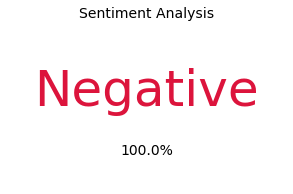

1/1 [==============================] - 0s 29ms/step


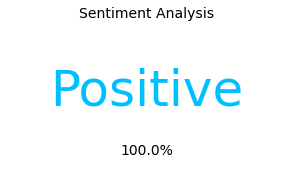

1/1 [==============================] - 0s 29ms/step


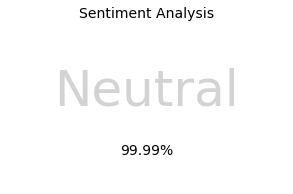

1/1 [==============================] - 0s 29ms/step


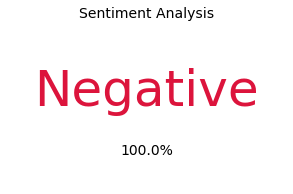

time: 5.84 s (started: 2022-11-24 19:43:25 +00:00)


In [ ]:
neg_com = "Waste of money, horrible and disgusting."
pos_com = "The prices are amazing and the shipping is really fast! Thank for everything amazon!"
neu_com = "App is average. Could be better but its not too bad. does the job"
test_com = " Really disappointed with this camera, hubby was late putting it up because of building work being done, hence this camera would of been sent back to to seller:::: we have 2 sannce cams which are brill and colour night vision but no audio, we thought we would try annke IP with audio...... big mistake.... looses connection all the time... the picture glitches and playback if your lucky to get? freezes and night vision although black and white is pretty clear but all in all for the price I would not waste your money. We have unfortunately gone past the return date and now stuck with a camera we cant use."

sentiment_analysis(neg_com, 'negative', model)
sentiment_analysis(pos_com, 'positive', model)
sentiment_analysis(neu_com, 'neutral', model)
sentiment_analysis(test_com, 'test', model)

In [ ]:
from google.colab import files

time: 615 µs (started: 2022-11-24 19:43:31 +00:00)


In [ ]:
def full_sentiment_analysis(file, foo, model):
  review_df = pd.read_csv(file, delimiter=",")
  proarg = []
  v = []

  for text in review_df['review']:

    if type(text) is not list:
      text = [text]
      text_prep = text_prep_pipeline.fit_transform(text)
      text_toke = tokenizer.texts_to_sequences(text_prep)
      matrix = pad_sequences(text_toke, padding='post', maxlen=200)
      proba = model.predict(matrix)
      a = proba.argmax()
      
      
      proarg = np.append(a, proarg)
      if proba.argmax() == 0:
        class_proba = proba[0][0]
        v.append(class_proba)
      
      elif proba.argmax() == 1:
        class_proba = proba[0][1]
        v.append(class_proba)

      elif proba.argmax() == 2:
        class_proba = proba[0][2]
        v.append(class_proba)

  total = sum(proarg)/len(proarg)
  per = round((sum(v)/len(v))*100,2)

  fig, ax = plt.subplots(figsize=(5, 3))

  if total <= 0.67:
    text = 'Negative'
    class_proba = per
    color = 'Crimson'

  elif total <= 1.33:
    text = 'Neutral'
    class_proba = per
    color = 'Lightgrey'

  elif total <= 2:
    text = 'Positive'
    class_proba = per
    color = 'DeepSkyBlue'

  ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
  ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
  ax.axis('off')
  ax.set_title('Sentiment Analysis', fontsize=14)
  fig.savefig(str(foo)+'_img.png')
  plt.show()
  files.download(str(foo)+'_img.png')

  #return proba

time: 3.18 ms (started: 2022-11-24 19:43:31 +00:00)


1/1 [==============================] - 0s 28ms/step


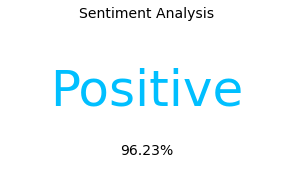

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 3.13 s (started: 2022-11-24 19:43:31 +00:00)


In [ ]:
full_sentiment_analysis('reviews.csv', 'review', model)

time: 3.13 s (started: 2022-11-24 19:43:31 +00:00)
